# Utilizam Little VGG pentru detectarea emotilor

## instruirea detectorului de emotii

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 6
img_rows, img_cols = 48, 48
batch_size = 100

train_data_dir = 'c:/Users/Harum/Documents/18/fer2013/train'
validation_data_dir = 'c:/Users/Harum/Documents/18/fer2013/validation'

# Utilizam  data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Using TensorFlow backend.
Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


# Keras importuri

In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense

# Keras modelul LittleVGG

In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: Al 2-lea CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: Al 3-lea CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: Al 4-lea CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: primul FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: AL 2-lea  FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
________________________________________________

# Instruire model

In [4]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("c:/Users/Harum/Documents/18/emotion_little_vgg_3v2.h5",
                             monitor="val_accuracy",#in loc de val_loss vom folosi val_accuracy
                             mode="max",#inloc de min folosim max
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_accurasy', #inloc de val_loss folosim val_accurasy
                          min_delta = 0, 
                          patience = 8,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                               min_delta = 0.0001)

# punem call backs intr-o lista callback 
callbacks = [earlystop, checkpoint, reduce_lr]

# vom folosi o rata de invatare foarte mica
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_train_samples = 28273
nb_validation_samples = 3534
epochs = 30

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
282/282 [==============================] - 276s 978ms/step - loss: 2.2686 - accuracy: 0.1924 - val_loss: 1.8844 - val_accuracy: 0.2486

Epoch 00001: val_accuracy improved from -inf to 0.24857, saving model to c:/Users/Harum/Documents/18/emotion_little_vgg_3v2.h5
Epoch 2/30
282/282 [==============================] - 29s 102ms/step - loss: 1.8508 - accuracy: 0.2172 - val_loss: 1.7894 - val_accuracy: 0.2708

Epoch 00002: val_accuracy improved from 0.24857 to 0.27082, saving model to c:/Users/Harum/Documents/18/emotion_little_vgg_3v2.h5
Epoch 3/30
282/282 [==============================] - 27s 96ms/step - loss: 1.7631 - accuracy: 0.2435 - val_loss: 1.6901 - val_accuracy: 0.2539

Epoch 00003: val_accuracy did not improve from 0.27082
Epoch 4/30
282/282 [==============================] - 27s 95ms/step - loss: 1.7357 - accuracy: 0.2591 - val_loss: 1.7198 - val_accuracy: 0.2478

Epoch 00004: val_accuracy did not improve from 0.27082
Ep

Found 3534 images belonging to 6 classes.
Confusion Matrix
[[235  36  21  72 107  20]
 [145  71  18  90  97 107]
 [ 31   7 755  41  22  23]
 [123  31 162 140  94  76]
 [ 89  30  43 191 231  10]
 [ 17  28  20  12   6 333]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.37      0.48      0.42       491
        Fear       0.35      0.13      0.19       528
       Happy       0.74      0.86      0.80       879
     Neutral       0.26      0.22      0.24       626
         Sad       0.41      0.39      0.40       594
    Surprise       0.59      0.80      0.68       416

    accuracy                           0.50      3534
   macro avg       0.45      0.48      0.45      3534
weighted avg       0.47      0.50      0.47      3534



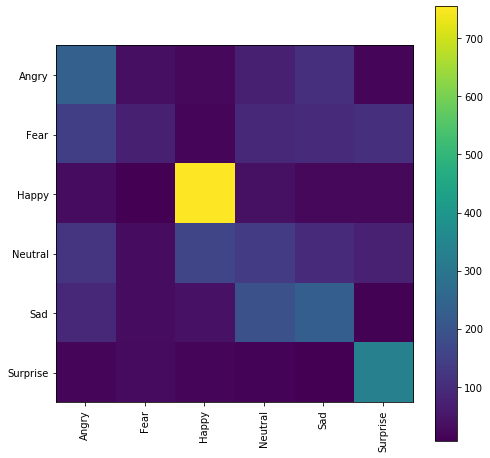

In [5]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28273
nb_validation_samples = 3534

# Ne trebuie sa recrem validation generator cu shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

# Incarcare modelului salvat

In [6]:
from keras.models import load_model

classifier = load_model("c:/Users/Harum/Documents/18/emotion_little_vgg_3v2.h5")

# optine straturile claselor

In [7]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 3534 images belonging to 6 classes.
{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}


# Testarea catorva imaginii din vaidation

In [8]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensiunea imaginilor
img_width, img_height = 48, 48

# Utilizam o rata de invatare foarte mica 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'c:/Users/Harum/Documents/18/fer2013/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

# Testarea unei singure imagini

In [9]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('c:/Users/Harum/Documents/18/Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    #converteste imaginea in alb-negru
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("rajeev.jpg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # faceți o predicție pe ROI, apoi căutați clasa
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Suprapune-ți emoția detectată în poza noastră
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

# Sa incercam asta cu webcam

In [10]:
import cv2
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('c:/Users/Harum/Documents/18/Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # converteste imaginea in alb-negru
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        #faceți o predicție pe ROI, apoi căutați clasa
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()  

# Detector emotilor,anilor si sexul 

## Incarcarea clasificatorilor

In [11]:
from pathlib import Path
import cv2
#import dlib
import sys
import numpy as np
import argparse
from contextlib import contextmanager
from wide_resnet import WideResNet
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.image import img_to_array

classifier = load_model("c:/Users/Harum/Documents/18/emotion_little_vgg_3v2.h5")
face_classifier = cv2.CascadeClassifier('c:/Users/Harum/Documents/18/Haarcascades/haarcascade_frontalface_default.xml')
#age_gender_classifier = load_model('c:/Users/Harum/Documents/18/weights.28-3.73.hdf5')
pretrained_model = "https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.28-3.73.hdf5"

# Testare Emotilor, anilor si sexul cu decteorul folosind webcam

In [12]:
emotion_classes = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Neutral', 4:'Sand', 5:'Surprise'}
modhash = 'fbe63257a054c1c5466cfd7bf14646d6'

In [13]:
def face_detector(img):
    #convert imaginea in alb-negru pentru detectare mai rapida
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return False, (0,0,0,0), np.zeros((1,48,48,3), np.uint8), img
    
    allfaces = []
    rects = []
    #aici se creaza acel patrad in jurul fatei
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
        roi = img[y:y+h, x:x+w]
        allfaces.append(roi)
        rects.append((x,w,y,h))
    return True, rects, allfaces, img

#######################################################################
#Definirea parametrilor modelului
depth = 16
k = 8
weight_file = None
margin = 0.4
image_dir = None

#Optine weight file
if not weight_file:
    weight_file = get_file("weights.28-3.73.hdf5", pretrained_model,
                                file_hash=modhash,
                                cache_subdir="pretrained_models", 
                                cache_dir=Path(sys.argv[0]).resolve().parent
                                )

#incarca modelul si weights
img_size = 64
model = WideResNet(img_size, depth=depth, k=k)()
model.load_weights(weight_file)
#################################################################################

#initializare webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    ret, rects, faces, image = face_detector(frame)
    preprocessed_faces_ag = []
    preprocessed_faces_emo = []
    #i=0
    if ret:
        for (i, face) in enumerate(faces):
            face_ag = cv2. resize(face, (64,64), interpolation=cv2.INTER_AREA)
            preprocessed_faces_ag.append(face_ag)
            
            face_gray_emo = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face_gray_emo = cv2.resize(face_gray_emo, (48,48), interpolation= cv2.INTER_AREA)
            
            face_gray_emo = face_gray_emo.astype('float')/255.0
            face_gray_emo = img_to_array(face_gray_emo)
            face_gray_emo = np.expand_dims(face_gray_emo, axis=0)
            preprocessed_faces_emo.append(face_gray_emo)

###################################################################
        #fa o predictie a anilor si sexului
        results = model.predict(np.array(preprocessed_faces_ag))
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()
##############################################################################
        #fa o predictie a emotilor
        emo_labels = []
        for (i, face) in enumerate(faces):
            preds = classifier.predict(preprocessed_faces_emo[i])[0]
            emo_labels.append(emotion_classes[preds.argmax()])

        #scrie rzultatul pentru ani si sex
        for (i, face) in enumerate(faces):
            label = "{}, {}, {}".format(int(predicted_ages[i]), 
                                        "F" if predicted_genders[i][0]> 0.6 else "M",
                                        emo_labels[i] )
         
         #Suprapune-ți emoția detectată în poza noastră
        for (i, face) in enumerate(faces):
             label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
             cv2.putText(image, label, label_position, cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 2)
    cv2.imshow("Emotion Detector", image)
    if cv2.waitKey(1) == 13:
         break

cap.release()
cv2.destroyAllWindows()                                       